In [99]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt
from pmdarima import auto_arima
import os


In [100]:
# Load the dataset
file_path = 'Data/nairobi_df.csv'
nairobi_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
nairobi_df.head()

,date,district,commodity,pricetype,standardized_price
0,2006-01-15,Nairobi,Maize,Wholesale,15.480000
1,2006-01-15,Nairobi,Maize,Wholesale,15.544444
2,2006-01-15,Nairobi,Potatoes,Wholesale,13.288600
3,2006-01-15,Nairobi,Sorghum,Wholesale,21.777778
4,2006-01-15,Nairobi,Milk,Retail,44.000000


In [101]:
# Filtering the dataset for maize in Nairobi and for wholesale prices only
maize_df = nairobi_df[(nairobi_df['commodity'] == 'Maize') & 
                      (nairobi_df['district'] == 'Nairobi') & 
                      (nairobi_df['pricetype'] == 'Wholesale')]

# Size of the filtered dataset
dataset_size = maize_df.shape

# Descriptive statistics for the relevant features
descriptive_stats = maize_df.describe(include='all')

dataset_size, descriptive_stats

((417, 5),
               date district commodity  pricetype  standardized_price
 count          417      417       417        417          417.000000
 unique         208        1         1          1                 NaN
 top     2021-04-15  Nairobi     Maize  Wholesale                 NaN
 freq             3      417       417        417                 NaN
 mean           NaN      NaN       NaN        NaN           31.837506
 std            NaN      NaN       NaN        NaN           12.277596
 min            NaN      NaN       NaN        NaN            8.911111
 25%            NaN      NaN       NaN        NaN           24.677778
 50%            NaN      NaN       NaN        NaN           31.800000
 75%            NaN      NaN       NaN        NaN           35.833333
 max            NaN      NaN       NaN        NaN           84.122222)

In [102]:
# Convert 'date' to datetime format and set as index
maize_df.loc[:, 'date'] = pd.to_datetime(maize_df['date'])
maize_df.set_index('date', inplace=True)

# Sort the dataset based on the index (date)
maize_df.sort_index(inplace=True)

# Display the first few rows to verify changes
maize_df.head()

,district,commodity,pricetype,standardized_price
date,,,,
2006-01-15,Nairobi,Maize,Wholesale,15.480000
2006-01-15,Nairobi,Maize,Wholesale,15.544444
2006-02-15,Nairobi,Maize,Wholesale,16.410000
2006-02-15,Nairobi,Maize,Wholesale,16.533333
2006-03-15,Nairobi,Maize,Wholesale,16.910000


In [103]:
# Checking for missing values in 'standardized_price'
missing_values = maize_df['standardized_price'].isnull().sum()

# Checking the frequency of the date entries
date_frequency = maize_df.index.to_series().diff().unique()

missing_values, date_frequency

(0,
 <TimedeltaArray>
 [NaT, '0 days', '31 days', '28 days', '30 days', '29 days', '91 days',
  '61 days']
 Length: 8, dtype: timedelta64[ns])

In [104]:
# Resampling the data to a monthly frequency, taking the average of prices in each month
monthly_maize_df = maize_df['standardized_price'].resample('M').mean()

# Displaying the first few rows of the resampled data
monthly_maize_df.head()

date
2006-01-31    15.512222
2006-02-28    16.471667
2006-03-31    16.788333
2006-04-30    17.065556
2006-05-31    17.881444
Freq: M, Name: standardized_price, dtype: float64

In [105]:
# Checking for missing values in the resampled monthly data
missing_values_monthly = monthly_maize_df.isnull().sum()

# Filling missing values with the mean (if any)
monthly_maize_filled_df = monthly_maize_df.fillna(monthly_maize_df.mean())

# Rechecking for missing values after filling
recheck_missing_values = monthly_maize_filled_df.isnull().sum()

missing_values_monthly, recheck_missing_values

(3, 0)

In [106]:
# Retrying the Augmented Dickey-Fuller test for stationarity on the filled dataset
adf_test_result_filled = adfuller(monthly_maize_filled_df)

# Extracting the p-value from the test results
adf_p_value_filled = adf_test_result_filled[1]

adf_p_value_filled

0.8121103067317086

4.3589813070513496e-14

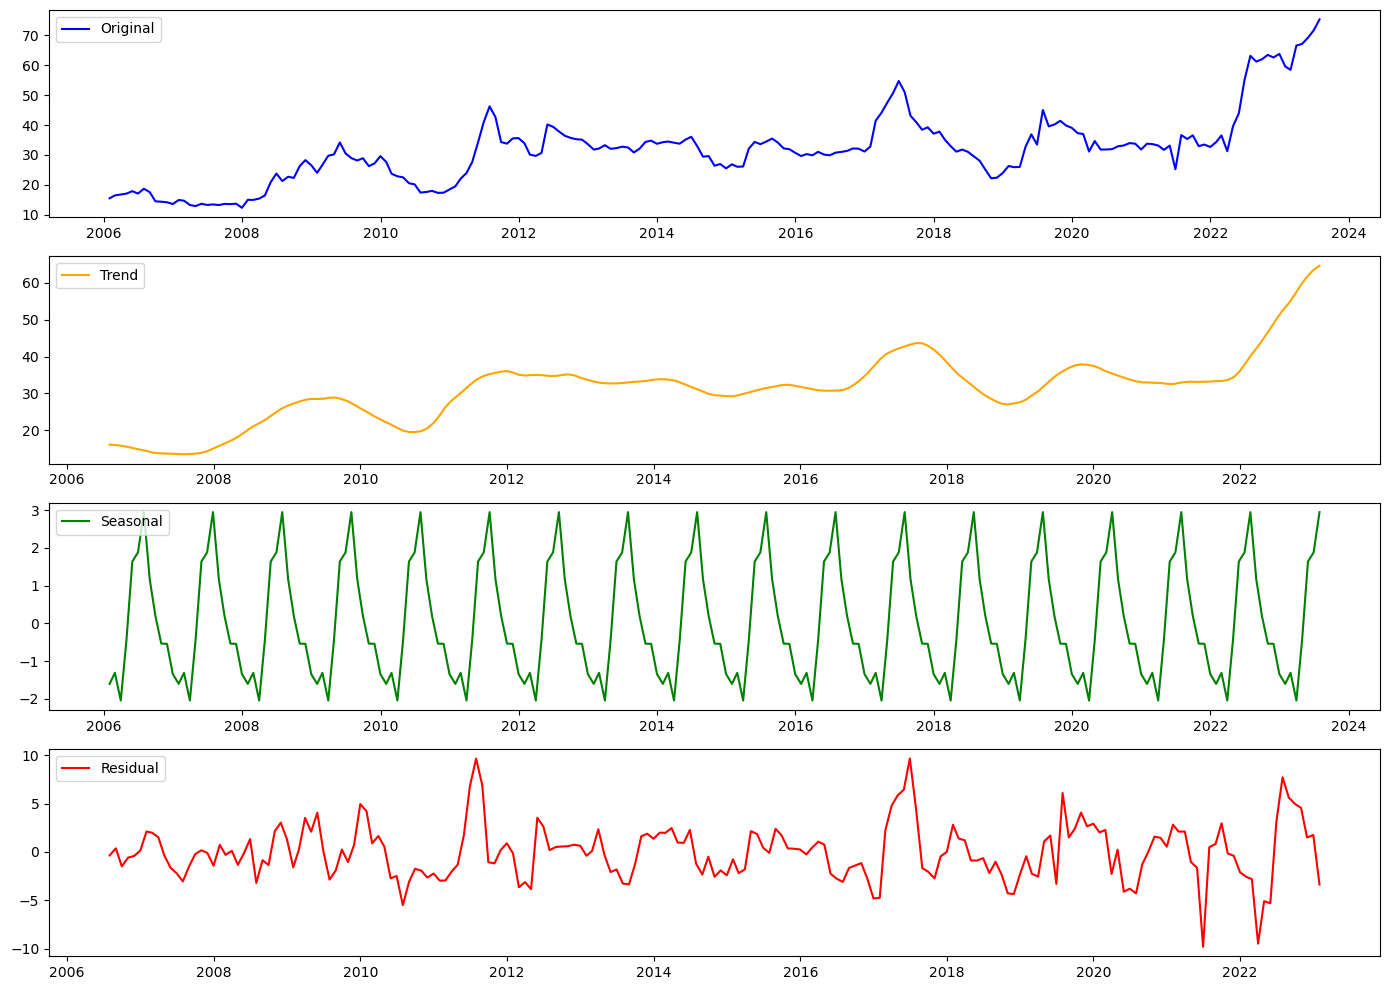

In [107]:

# Applying differencing to make the series stationary
monthly_maize_diff = monthly_maize_filled_df.diff().dropna()

# Performing the Augmented Dickey-Fuller test again on the differenced data
adf_test_result_diff = adfuller(monthly_maize_diff)
adf_p_value_diff = adf_test_result_diff[1]

# Seasonality and trend analysis using seasonal decomposition
decomposition = seasonal_decompose(monthly_maize_filled_df, model='additive')

# Plotting the original series, trend, seasonal, and residual components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(monthly_maize_filled_df, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()

adf_p_value_diff

In [108]:
# Splitting the dataset into training and testing sets
# We'll use 80% of the data for training and 20% for testing
train_size = int(len(monthly_maize_diff) * 0.8)
train_data, test_data = monthly_maize_diff[0:train_size], monthly_maize_diff[train_size:]

# Checking the sizes of the training and testing sets
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

train_data_size, test_data_size

(168, 42)

In [109]:
# Function to train and evaluate an ARIMA model
def train_evaluate_arima(train, test, arima_order):
    """
    Train an ARIMA model and evaluate its performance.
    
    :param train: Training dataset
    :param test: Testing dataset
    :param arima_order: Tuple of ARIMA parameters (p, d, q)
    :return: Root Mean Squared Error (RMSE) of the model
    """
    history = [x for x in train]
    predictions = []
    
    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # Calculate and return RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, predictions

In [110]:
# Baseline ARIMA model with initial parameters (p=1, d=1, q=1)
arima_order = (1, 1, 1)
baseline_rmse, baseline_predictions = train_evaluate_arima(train_data, test_data, arima_order)

baseline_rmse

4.208414028369863

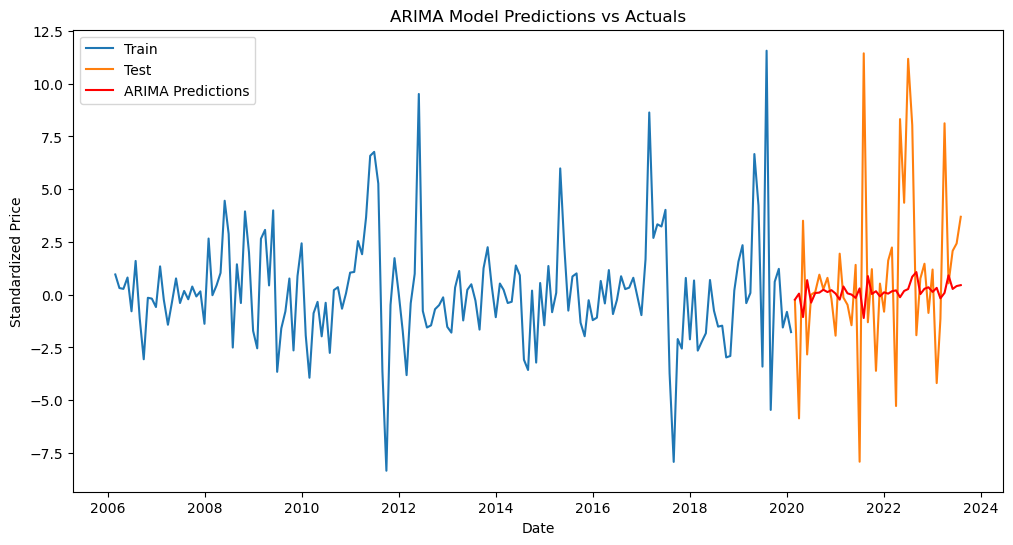

In [111]:
# Fit the ARIMA model
model = ARIMA(train_data, order=arima_order)
model_fit = model.fit()

model_fit.summary()

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, baseline_predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Standardized Price')
plt.legend()
plt.show()

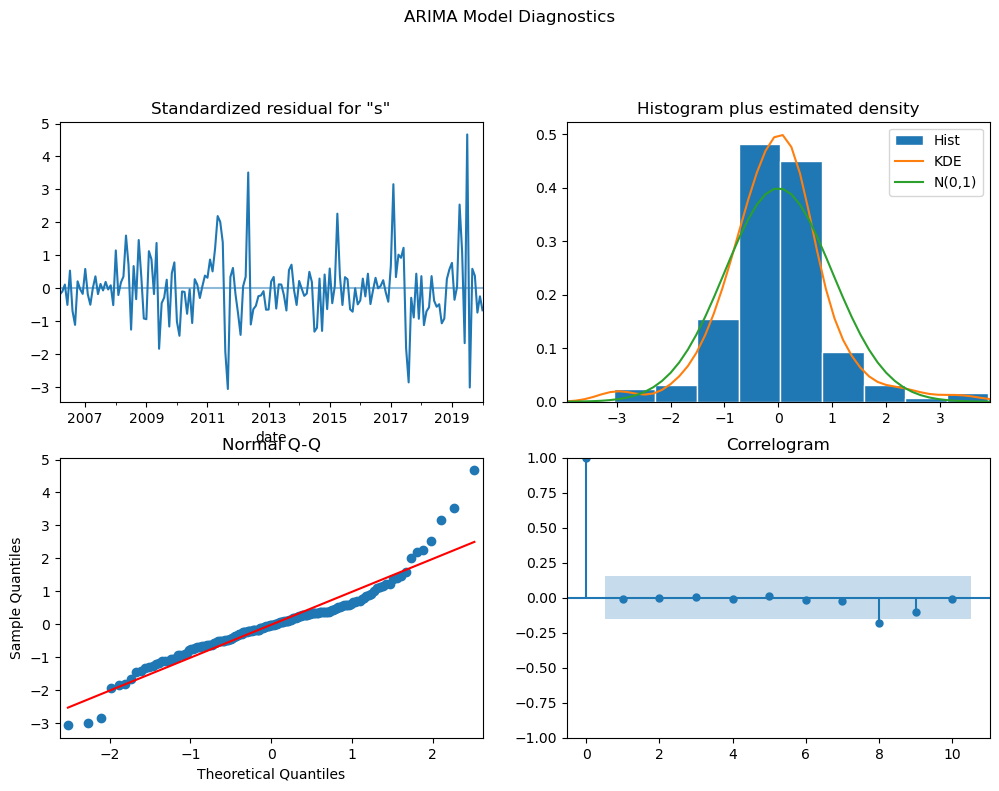

In [112]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('ARIMA Model Diagnostics', y=1.02)
plt.show()

In [113]:
# SARIMA Order
sarima_order = (1, 1, 1, 12)  # (p, d, q, S) for seasonal order - S is 12 for monthly data
# Train and fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=sarima_order)
sarima_model_fit = sarima_model.fit(disp=False)
sarima_model_fit.summary()

# Forecasting
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test_data))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Calculate RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast_mean))
print(f'SARIMA RMSE: {sarima_rmse:.2f}')

SARIMA RMSE: 4.04


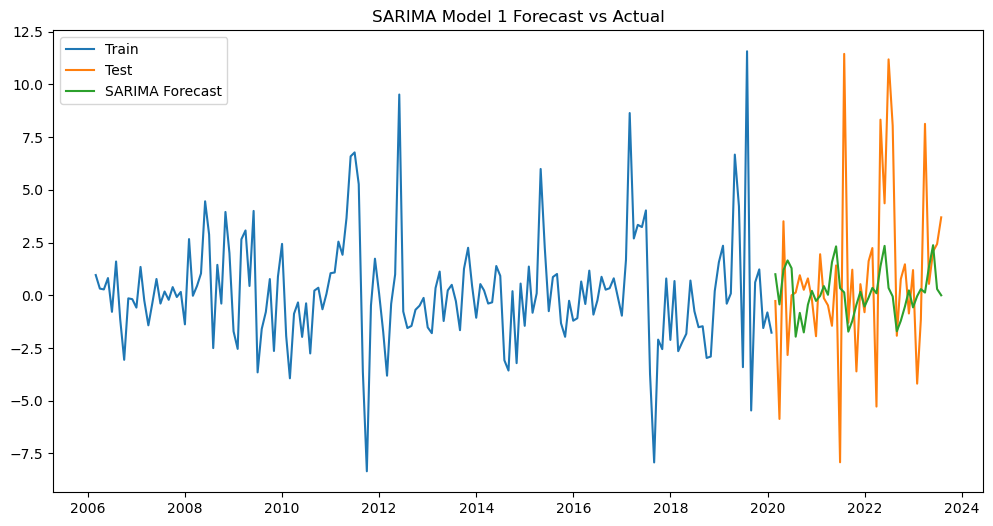

In [114]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='SARIMA Forecast')
plt.title('SARIMA Model 1 Forecast vs Actual')
plt.legend()
plt.show()

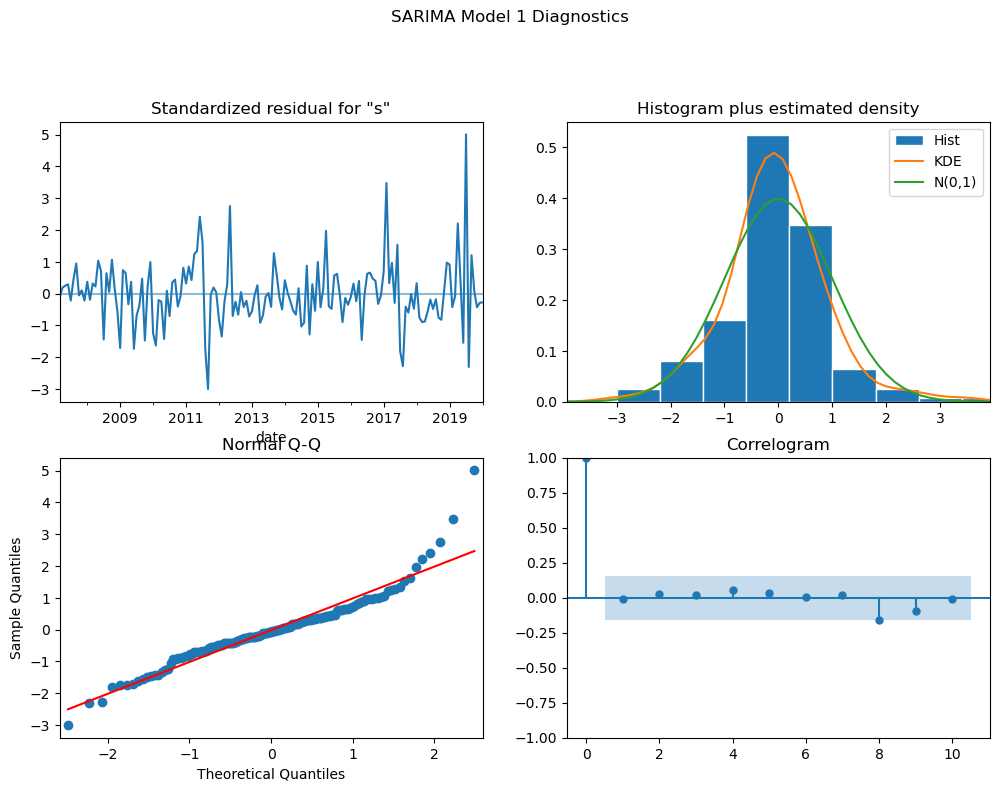

In [115]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('SARIMA Model 1 Diagnostics', y=1.02)
plt.show()

In [116]:
# SARIMA Order
sarima_order = (1, 2, 1, 12)  # (p, d, q, S) for seasonal order - S is 12 for monthly data
# Train and fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=sarima_order)
sarima_model_fit2 = sarima_model.fit(disp=False)
sarima_model_fit2.summary()

# Forecasting
sarima_forecast = sarima_model_fit2.get_forecast(steps=len(test_data))
sarima_forecast_mean2 = sarima_forecast.predicted_mean

# Calculating RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast_mean2))
print(f'SARIMA RMSE: {sarima_rmse:.2f}')

SARIMA RMSE: 4.07


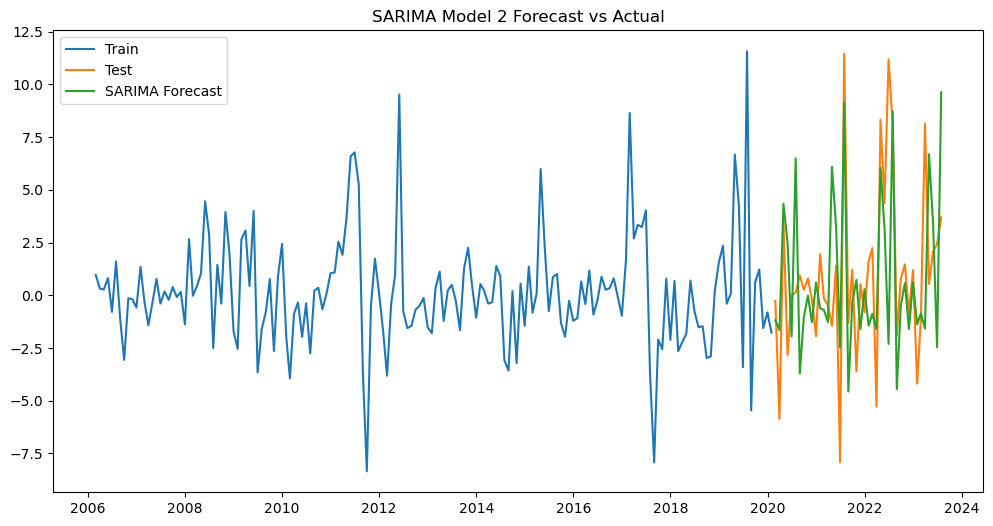

In [117]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean2, label='SARIMA Forecast')
plt.title('SARIMA Model 2 Forecast vs Actual')
plt.legend()
plt.show()

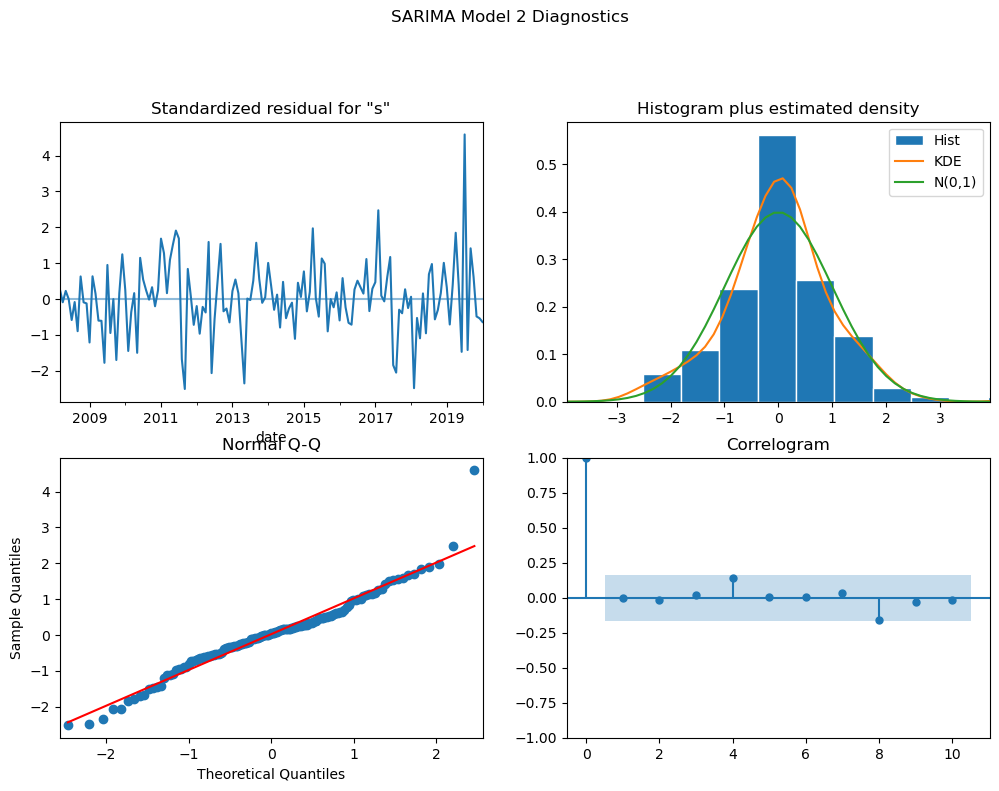

In [118]:
# Plot diagnostics
sarima_model_fit2.plot_diagnostics(figsize=(12, 8))
plt.suptitle('SARIMA Model 2 Diagnostics', y=1.02)
plt.show()

In [119]:
import joblib

# Assuming 'sarima_model_fit2' is your trained SARIMA model
joblib.dump(sarima_model_fit2, 'sarimax_model_monthly.pkl')

['sarimax_model_monthly.pkl']

ADF Statistic for Maize: -0.5185390742422722
p-value for Maize: 0.8883476652103298
Decomposition Plots for Maize:


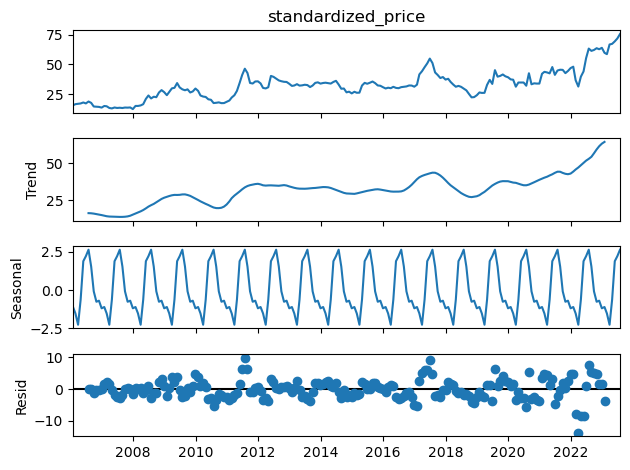

Training SARIMA model for Maize...
Saved SARIMA model for Maize as sarima_model_Maize.pkl
ADF Statistic for Potatoes: -2.1193662884077327
p-value for Potatoes: 0.23679895767792486
Decomposition Plots for Potatoes:


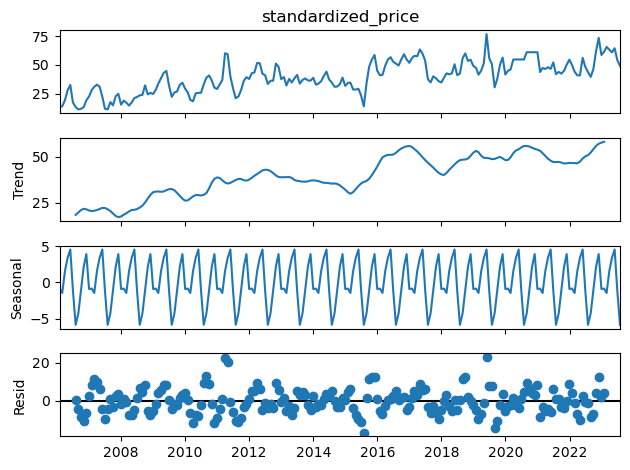

Training SARIMA model for Potatoes...
Saved SARIMA model for Potatoes as sarima_model_Potatoes.pkl
ADF Statistic for Sorghum: -1.1824319743723286
p-value for Sorghum: 0.6811070119080757
Decomposition Plots for Sorghum:


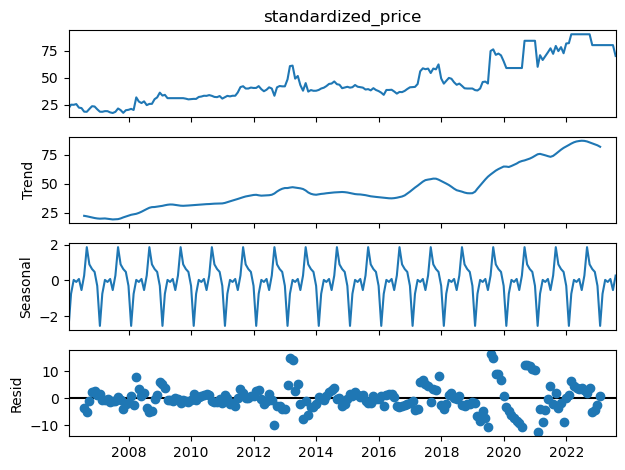

Training SARIMA model for Sorghum...


c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saved SARIMA model for Sorghum as sarima_model_Sorghum.pkl
ADF Statistic for Milk: -1.0881506717299674
p-value for Milk: 0.7197740739182119
Decomposition Plots for Milk:


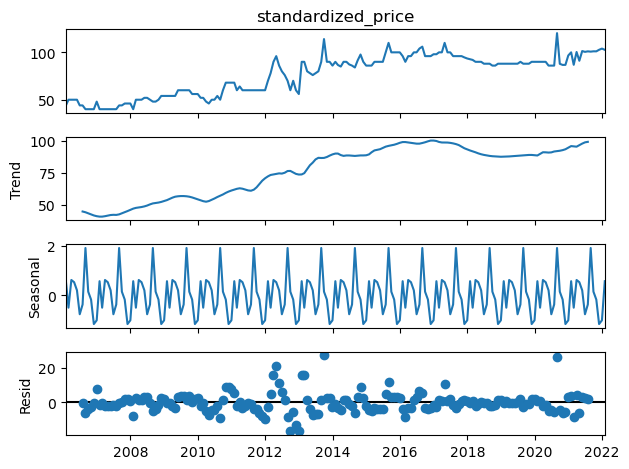

Training SARIMA model for Milk...


c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saved SARIMA model for Milk as sarima_model_Milk.pkl
ADF Statistic for Oil (vegetable): -2.403152646076485
p-value for Oil (vegetable): 0.14084857407302853
Decomposition Plots for Oil (vegetable):


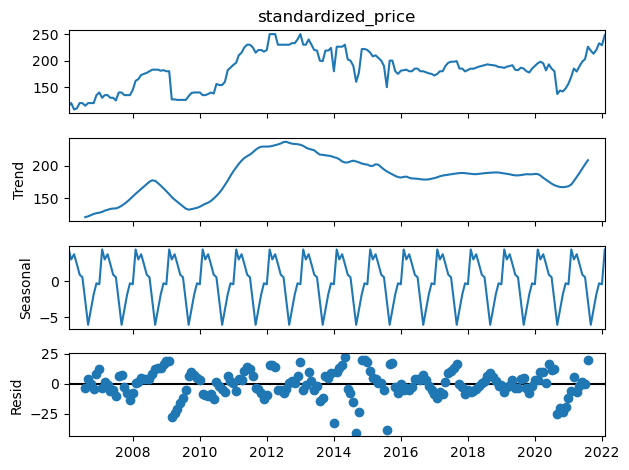

Training SARIMA model for Oil (vegetable)...


c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saved SARIMA model for Oil (vegetable) as sarima_model_Oil (vegetable).pkl
ADF Statistic for Beans: 0.9082908083030594
p-value for Beans: 0.9931975753349831
Decomposition Plots for Beans:


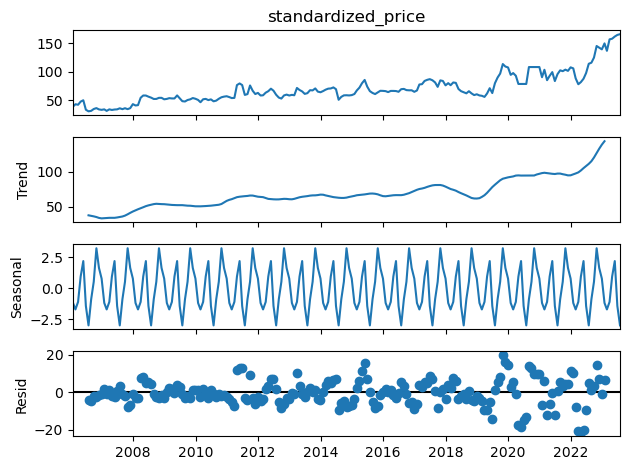

Training SARIMA model for Beans...


c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Saved SARIMA model for Beans as sarima_model_Beans.pkl


In [122]:
def process_and_save_models(data, commodity, sarima_order, seasonal_order):
    # Filter data for the commodity
    commodity_data = data[data['commodity'] == commodity].copy()
    commodity_data.set_index('date', inplace=True)
    commodity_data.sort_index(inplace=True)
    monthly_data = commodity_data['standardized_price'].resample('M').mean().fillna(method='ffill')
    
    # Check for stationarity
    adf_test = adfuller(monthly_data)
    print(f'ADF Statistic for {commodity}: {adf_test[0]}')
    print(f'p-value for {commodity}: {adf_test[1]}')
    
    # Decompose the time series and plot
    decomposition = seasonal_decompose(monthly_data)
    print(f'Decomposition Plots for {commodity}:')
    decomposition.plot()
    plt.show()
    
    # Train SARIMA model
    print(f'Training SARIMA model for {commodity}...')
    sarima_model = SARIMAX(monthly_data, order=sarima_order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)
    
    # Save model
    model_filename = f'sarima_model_{commodity}.pkl'
    joblib.dump(sarima_model_fit, model_filename)
    print(f'Saved SARIMA model for {commodity} as {model_filename}')

# Assuming nairobi_df is your DataFrame and contains a 'standardized_price' column
nairobi_df['date'] = pd.to_datetime(nairobi_df['date'])
unique_commodities = nairobi_df['commodity'].unique()

# SARIMA order parameters
sarima_order = (2, 1, 2)  # Non-seasonal order
seasonal_order = (1, 2, 1, 12)  # Seasonal order

# Process and save models for each commodity
for commodity in unique_commodities:
    process_and_save_models(nairobi_df, commodity, sarima_order, seasonal_order)